#### Imports

In [2]:
import sys
import os
import re
import pandas as pd
import numpy as np
import os.path as path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import itemfreq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import stop_words
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt

In [3]:
plt.rc('font', family='serif', size = 10)
plt.rc('figure', figsize=(15,8))
# plt.rc('lines', linewidth=2)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=32, labelsize=25) 
plt.rc('legend', fontsize=18) 
plt.rc('axes', titlepad=15, labelpad=15, grid=True, titleweight='normal', labelweight='normal')
plt.rc('grid', linestyle='dashed', linewidth=0.5)

#### Data Read

In [4]:
og_location = os.path.abspath(os.path.realpath(os.path.join(os.getcwd(), '..\Data')))
# reading train and test files
Train = pd.read_csv(og_location + "\drugsComTrain_raw.csv", encoding= "utf-8")
Test = pd.read_csv(og_location + "\drugsComTest_raw.csv", encoding= "utf-8")

#### Pre-processing

In [5]:
# merging train and test data for pre-processing
merged_data = pd.concat([Train,Test],ignore_index=True)
# remove NAs and drop duplicates
merged_data = merged_data.dropna(axis=0).drop_duplicates()
# remove certain condition that are useless
span_data = merged_data[merged_data['condition'].str.contains('</span>',case=False,regex=True) == True]
merged_data.drop(span_data.index, axis = 0, inplace=True)

In [6]:
# function to remove html characters from the data
def remove_html(raw_review):
    # 1. Delete HTML 
    review_text = ''.join(BeautifulSoup(raw_review, 'html.parser').get_text())
    return (review_text)

In [7]:
review_text = merged_data['review'].apply(remove_html)
# remove special characters
review_text = review_text.map(lambda x: re.sub(r'[^\w]', ' ', x))  
# 3. remove added white spaces
review_text = review_text.map(lambda x: re.sub("\s\s+", " ", x))
# 4. remove delimiters 
X = review_text.map(lambda x: x.replace("\n",'').replace("\r",'').replace("\t", '')).values

#### Rating Distribution

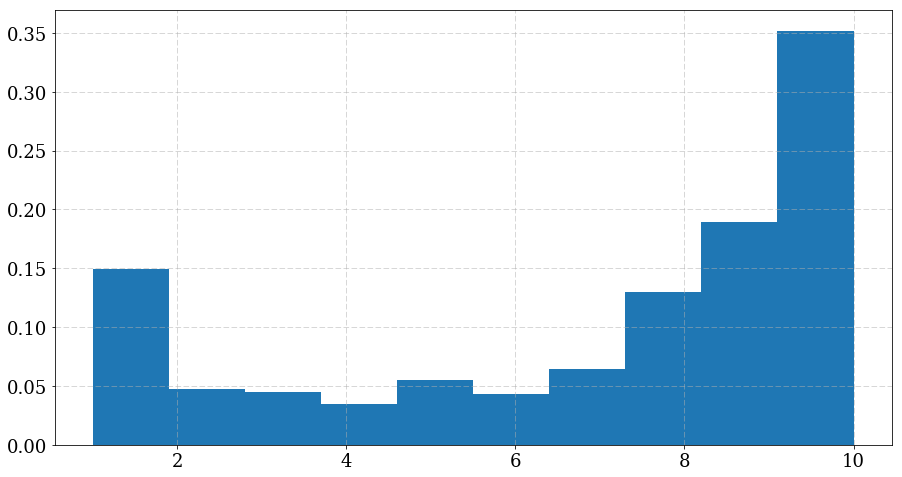

In [8]:
plt.hist(merged_data['rating'], normed = True)
plt.show()

In [9]:
# Percentage distribution of data 
dist = pd.DataFrame(round(merged_data.groupby(['rating']).count()['uniqueID']/len(merged_data) * 100,3))

In [10]:
dist.columns = ['perc']

In [11]:
dist

,perc
rating,
1,13.456
2,4.298
3,4.047
4,3.091
5,4.974
6,3.923
7,5.827
8,11.648
9,17.062


#### Skewed data check for rating and creating target labels

In [12]:
# creating target labels
y = merged_data['rating'].apply(lambda x: -1 if x < 3 else x)
y = y.apply(lambda x: 0 if (2 < x < 9) else x)
y = y.apply(lambda x: 1 if  x > 8 else x).values

In [13]:
y.value_counts()/len(y)

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [14]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#### stopwords experimentation

In [17]:
stop = list(stop_words.ENGLISH_STOP_WORDS)
vocab = list(count_vectorizer.vocabulary_.items())
stop_list = []
for i in range(0, len(vocab)):
    for j in range(0, len(stop)):
        if vocab[i][0] == stop[j]:
            if vocab[i][1] > np.ceil(len(vocab) * 0.7):
                #print(vocab[i])
                stop_list.append(vocab[i][0])
stop_list = frozenset(stop_list)  

#### Min_df  Max_df value select

In [ ]:
def min_vectorizers():
    min_df = []
    for i in range(1,11):
        vect = CountVectorizer(encoding='latin-1', lowercase = True, binary=True, min_df = i, stop_words='english')
        vecs_count = vect.fit_transform(X_train)
        min_df.append(vecs_count.shape[1])
    return min_df

def max_vectorizers():
    max_df = []
    for i in range(1,11):
        vect = CountVectorizer(encoding='latin-1', lowercase = True, binary=True, max_df = i/10, stop_words='english')
        vecs_count = vect.fit_transform(X_train)
        max_df.append(vecs_count.shape[1])
    return max_df

In [64]:
max_df = max_vectorizers()
min_df = min_vectorizers()

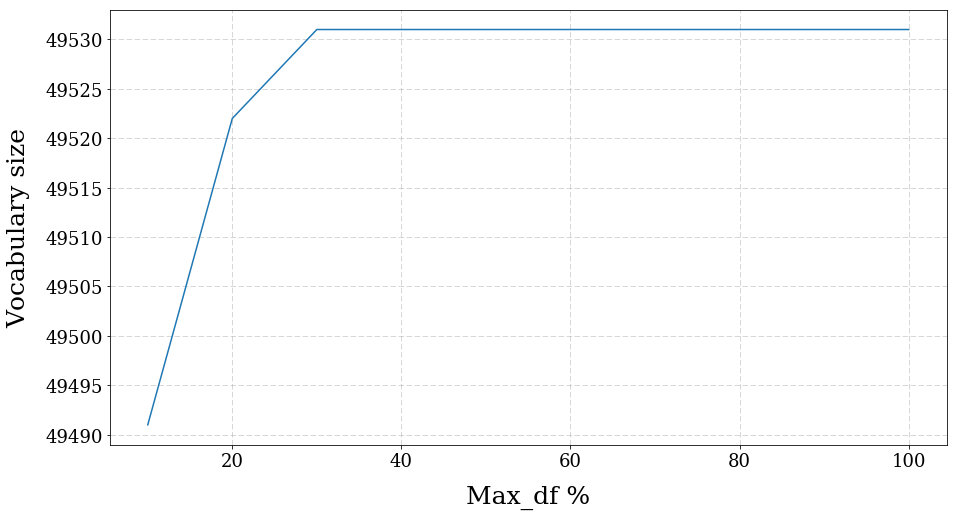

In [68]:
plt.plot(np.linspace(10,100,10), max_df)
plt.ylabel('Vocabulary size')
plt.xlabel('Max_df %')
plt.show()

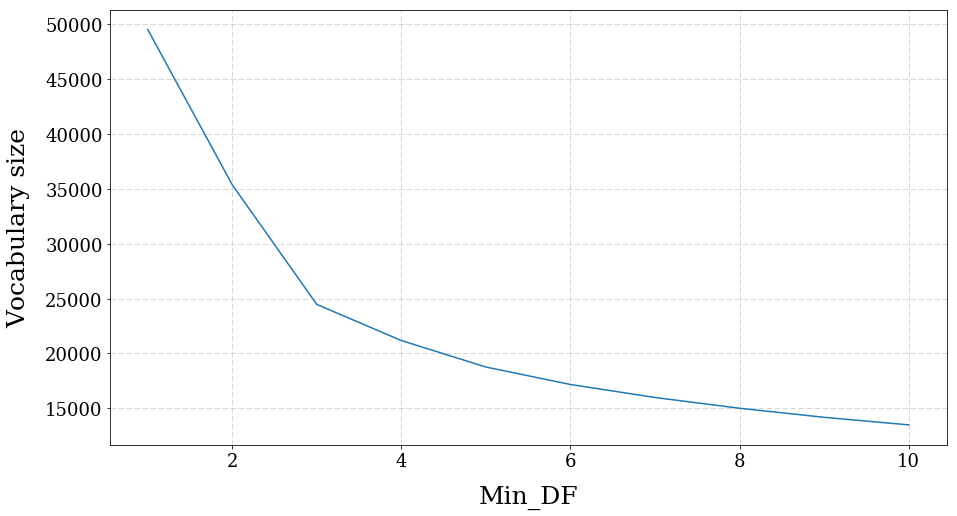

In [73]:
plt.plot(np.linspace(1,10,10), min_df)
plt.ylabel('Vocabulary size')
plt.xlabel('Min_DF')
plt.show()

In [18]:
# declare vectorizer
count_vectorizer = CountVectorizer(encoding='latin-1', binary = True, lowercase = True, min_df = 3, max_df = 0.7, ngram_range = (1,2), stop_words=stop_list)
# vocabulary creation
X_train_vec = count_vectorizer.fit_transform(X_train)
X_test_vec = count_vectorizer.transform(X_test)
print(len(count_vectorizer.vocabulary_))
print("Train Data",X_train_vec.shape)
print("Test Data",X_test_vec.shape)

382802
Train Data (159523, 382802)
Test Data (53175, 382802)


#### Models

In [371]:
# initialize the LinearSVC model
svm_clf = LinearSVC(C=1)

# use the training data to train the model
svm_clf.fit(X_train_vec,y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [372]:
svm_clf.score(X_test_vec,y_test)

0.8548189938881053

In [426]:
# initialize the MNB model
nb_clf= MultinomialNB()

# use the training data to train the MNB model
nb_clf.fit(X_train_vec,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Use Boolean vectorizer

In [19]:
bernoulliNB_clf = BernoulliNB()
bernoulliNB_clf.fit(X_train_vec,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [428]:
np.round(nb_clf.score(X_test_vec,y_test) * 100, 3)

73.518

In [20]:
np.round(bernoulliNB_clf.score(X_test_vec,y_test) * 100, 3)

73.22

#### Predictions

In [377]:
y_pred_B = bernoulliNB_clf.predict(X_test_vec)
y_pred_mnb = nb_clf.predict(X_test_vec)
y_pred_svm = svm_clf.predict(X_test_vec)

In [378]:
# Cosine similarity
cos_sim = cosine_similarity([y_pred_B,y_pred_mnb,y_pred_svm])
print(cos_sim)

[[1.         0.91596346 0.72859549]
 [0.91596346 1.         0.74246532]
 [0.72859549 0.74246532 1.        ]]


#### Confusion matrix and F-scores

##### SVM

In [379]:
target_labels = [-1,0,1]
target_names = ['-1','0','1']

In [380]:
confusion_matrix(y_test, y_pred_svm, labels= target_labels)

array([[ 7870,  1031,   492],
       [ 1078, 14222,  2559],
       [  411,  2149, 23363]])

In [381]:
print(classification_report(y_test, y_pred_svm, target_names=target_names))

             precision    recall  f1-score   support

         -1       0.84      0.84      0.84      9393
          0       0.82      0.80      0.81     17859
          1       0.88      0.90      0.89     25923

avg / total       0.85      0.85      0.85     53175



In [382]:
# Extreme misclassification percentage
(confusion_matrix(y_test, y_pred_svm, labels= target_labels)[0][2] + confusion_matrix(y_test, y_pred_svm, labels= target_labels)[2][0])/len(y_test) * 100

1.6981664315937939

##### MNB

In [383]:
confusion_matrix(y_test, y_pred_mnb, labels= target_labels)

array([[ 6765,  1856,   772],
       [ 1939, 11664,  4256],
       [  830,  4087, 21006]])

In [384]:
print(classification_report(y_test, y_pred_mnb, target_names=target_names))

             precision    recall  f1-score   support

         -1       0.71      0.72      0.71      9393
          0       0.66      0.65      0.66     17859
          1       0.81      0.81      0.81     25923

avg / total       0.74      0.74      0.74     53175



In [385]:
# Extreme misclassification percentage
(confusion_matrix(y_test, y_pred_mnb, labels= target_labels)[0][2] + confusion_matrix(y_test, y_pred_mnb, labels= target_labels)[2][0])/len(y_test) * 100

3.012693935119887

##### BNB

In [386]:
confusion_matrix(y_test, y_pred_B, labels= target_labels)

array([[ 6821,  1397,  1175],
       [ 2048, 10513,  5298],
       [  753,  3680, 21490]])

In [387]:
print(classification_report(y_test, y_pred_B, target_names=target_names))

             precision    recall  f1-score   support

         -1       0.71      0.73      0.72      9393
          0       0.67      0.59      0.63     17859
          1       0.77      0.83      0.80     25923

avg / total       0.73      0.73      0.73     53175



In [388]:
# Extreme misclassification percentage
(confusion_matrix(y_test, y_pred_B, labels= target_labels)[0][2] + confusion_matrix(y_test, y_pred_B, labels= target_labels)[2][0])/len(y_test) * 100

3.6257639868359193

In [389]:
# Common_list in MNB, BNB,  for prediction class 1 and wrongly predicted as -1
err_cnt = 0

for i in range(0, len(y_test)):
    if((y_test[i]==1) and (y_pred_svm[i]==-1) and (y_pred_mnb[i] == -1) and (y_pred_B[i] == -1)):
        print(X_test[i])
        print('-----',i)

        err_cnt = err_cnt+1
print("errors:", err_cnt)

 So I had a UTI and was told to take a certain antibiotic After doing so I ended up getting a yeast infection due to the antibiotics killing off the good bacteria as well as the bad I had been forewarned that this could happen so caught the YI the day it came about I called into my doc and was prescribed this med I took it at circa 12 pm It is now 1 am same day and all chunky white discharge is completely gone Hopefully there will be no return of it tomorrow I give it 10 10 
----- 222
 I took victoza for well over a year and it improved my blood sugar readings tremendously My A1C had been as high as 9 and it got down to 6 9 with victoza However I was sick SO MUCH Constant diarrhea burping the nasty boiled egg kind and extreme nausea and vomiting I finally started tracking my sick days and in one month I was sick 4 days And by sick I mean throwing up every few minutes all day long I had several tests done and the only thing discovered was that I digest food slower than normal which is w

In [390]:
# Common_list in MNB, BNB, for prediction class -1 and wrongly predicted as 1
err_cnt = 0

for i in range(0, len(y_test)):
    if((y_test[i]== -1) and (y_pred_svm[i]==1) and (y_pred_mnb[i] == 1) and (y_pred_B[i] == 1)):
        print(X_test[i])
        print('-----',i)

        err_cnt = err_cnt+1
print("errors:", err_cnt)  

 My pain Dr started me on 10mg x 2 per day after a few years on 7 5 hydros 4 x per day After the 1st week and some withdrawal symptoms they give no relief Maybe Dr started me too low mg and see him next day I hope he ups mg to at least 15 and 20 probably will be better He said he can add the old hydro for breakthrough pain but at this point I feel at least two 7 5mg per day and that s only 2 less than before He should go to 20mg 2x per as I have a bad spine from head to tail facet arthritis Spinal stenosis Spondylolisthesis deteriorating disk and spinal neuropathy I m through I covered them all 
----- 64
 I have not gained any comfort using this drug 
----- 131
 Here is my experience i had cheated on my bf I know totally stuffed up but I m human I cheated with an ex I knew I was ovulating so I told myself nope go get the plan b I went to walgreens I seen the plan b it was expensive so i went with Take action I TOOK IT IMMEDIATELY 3HRS AFTER THE DEED WAS DONE Now 4 weeks I m pregnant 
-

In [222]:
negative_ranks = sorted(zip(svm_clf.coef_[-1], count_vectorizer.get_feature_names()))
top_neg= []
## get the 10 features that are best indicators of negative sentiment 
negative_10 = negative_ranks[-50:]
print("Negative words")
for i in range(0, len(negative_10)):
    print(negative_10[i])
    top_neg.append(negative_10[i][1])

Negative words
(0.7484984183355656, 'healed')
(0.7513279733291812, 'stop diarrhea')
(0.7538634689934383, 'is wonder')
(0.7572787731656824, 'drug however')
(0.7582748080018337, 'pain nausea')
(0.7590030222342588, 'hero')
(0.7621237653903468, 'started helping')
(0.7626051539589228, 'hypertension control')
(0.7629589109340561, 'quite tired')
(0.7639958989657092, 'gained alot')
(0.7666821138245162, 'terrible nauseous')
(0.7689553356738035, 'hasn caused')
(0.7739845175484283, 'because trying')
(0.78036589650736, 'miraculous')
(0.7846830754677604, 'but expensive')
(0.7847646894017712, 'nightmares have')
(0.7895585105839594, 'exceptional')
(0.790335723653025, 'fantastic')
(0.7920588416541369, 'much control')
(0.7964204059307571, 'not returned')
(0.800807281959687, 'of gi')
(0.8026743336724189, 'pee now')
(0.8043543511955604, 'have serotonin')
(0.8057473898533766, 'notice improvement')
(0.8115214666285185, 'first choice')
(0.8135213087264858, 'helped stop')
(0.815792928347953, 'cant make')
(0.

In [223]:
neutral_ranks = sorted(zip(svm_clf.coef_[0], count_vectorizer.get_feature_names()))
top_neu= []
## get the 10 features that are best indicators of neutral sentiment
neutral_10 = neutral_ranks[-50:]
print("Neutral words")
for i in range(0, len(neutral_10)):
    print(neutral_10[i])
    top_neu.append(neutral_10[i][1])

Neutral words
(0.7677870701241536, 'no better')
(0.7706397372616157, 'no lessening')
(0.7709039063882734, 'go blind')
(0.7730348025548021, 'got short')
(0.7739458727708853, 'prednisone causes')
(0.774466003198748, 'not helped')
(0.7755931455410283, 'no result')
(0.7801188350125403, 'insomnia nausea')
(0.7855142895313314, 'not effective')
(0.791282805810498, 'me anxiety')
(0.797311342202994, 'notice an')
(0.7995136852388014, 'worked much')
(0.8040495839522896, 'caused hair')
(0.8058852844569684, 'but diarrhea')
(0.8152422019933785, 'terrible akathisia')
(0.816859065688581, 'vomiting problems')
(0.8246900345761369, 'tiredness on')
(0.8269972508468848, 'not working')
(0.8327520170705421, 'didn work')
(0.8378448948399032, 'have orgasm')
(0.8390378074978903, 'depression couldn')
(0.8418098147741075, 'don recommend')
(0.848210581242252, 'dramatic weight')
(0.848605117652582, 'any good')
(0.8520923867478932, 'never worked')
(0.8634632495560479, 'infections but')
(0.8726823974602063, 'me panic

In [224]:
positive_ranks = sorted(zip(svm_clf.coef_[1], count_vectorizer.get_feature_names()))
top_pos = []
## get the 10 features that are best indicators of neutral sentiment
positive_10 = positive_ranks[-50:]
print("Positive words")
for i in range(0, len(positive_10)):
    print(positive_10[i])
    top_pos.append(positive_10[i][1])

Positive words
(0.9215753057793346, 'indapamide')
(0.9222274352051076, 'relieves pain')
(0.923903797447393, 'had oral')
(0.9242304178230125, 'experience shortness')
(0.926468793751166, 'horrible hot')
(0.9326971350613328, 'an because')
(0.9378255038724412, 'endlessly')
(0.9399122250595842, 'me shakey')
(0.9434245139996842, 'love xanax')
(0.9446548296987453, 'works about')
(0.9452010913028703, 'self now')
(0.9506710427208367, 'minimal relief')
(0.950937218606507, 'use med')
(0.9533685419393072, 'extremely for')
(0.9579596093859037, 'tastes great')
(0.9587664604915378, 'hydrocodone works')
(0.9662830908642295, 'good generic')
(0.970801876255555, 'always effective')
(0.9762364297813425, 'neurontin has')
(0.9807672032647445, 'severe long')
(0.9843878079191737, 'aleve helps')
(0.9871121176605276, 'years helps')
(0.9953210735038112, 'help prozac')
(0.9977751771150237, 'depression did')
(1.0010648476090402, 'works okay')
(1.0020351904899514, 'product few')
(1.005854618689722, 'always helped')

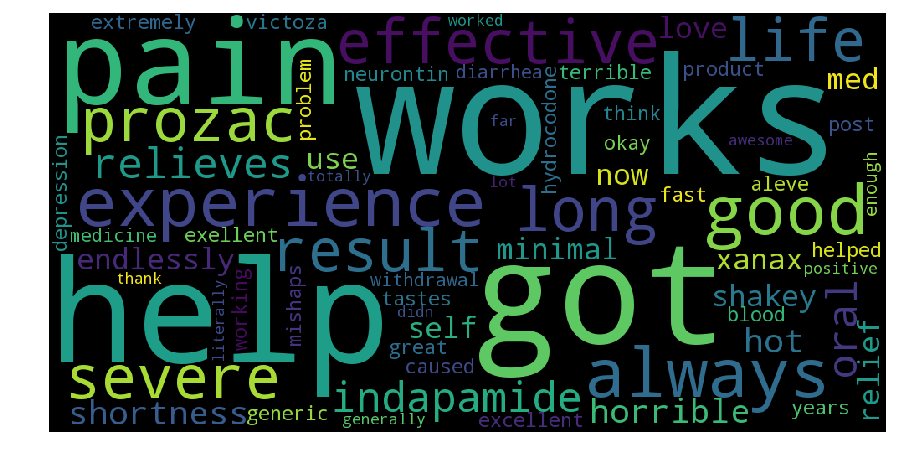

In [239]:
k = (' '.join(top_pos))
wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');
plt.show()

#### Checking for binary classifiers

In [284]:
# declare vectorizer
count_vectorizer = CountVectorizer(encoding='latin-1', lowercase = True, min_df = 3, max_df = 0.7, ngram_range = (1,2), stop_words=stop_list)
#class_list = []
for i in range(2,11):
    class_label = i
    # creating target labels
    y = merged_data['rating'].apply(lambda x: 0 if x == class_label else 1)
    
    # dividing train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    # vocabulary creation
    X_train_vec = count_vectorizer.fit_transform(X_train)
    X_test_vec = count_vectorizer.transform(X_test)
    
    # initialize the LinearSVC model
    svm_clf = LinearSVC(C=1)
    
    # use the training data to train the model
    svm_clf.fit(X_train_vec,y_train)
    
    # finding top words for the respective class
    feature_ranks = sorted(zip(svm_clf.coef_[0], count_vectorizer.get_feature_names()))
    
    class_words = feature_ranks[-50:]
    
    class_list_temp = []
    for i in range(0, len(class_words)):
        class_list_temp.append(class_words[i][1])
    
    class_list.append(class_list_temp)

#### Ambiguity based on conjunction

In [314]:
conjunction_list= ['and','but','moreover','in addition','as long as','only if','when','in case','assumption','additionally','further','furthermore','along with','as well as','also','plus','if','unless','even if','even until']

In [327]:
mystring = ['I am going and found this but cannot go now', 'moreover i am going when i would be good just in case if i dont']

In [391]:
conj_count_list = []
for i in range(0, len(X)):
    conj_count = 0
    for j in conjunction_list:
        if X[i].find(j) != -1:
            conj_count +=1
    conj_count_list.append(conj_count)
conj_df = {'conj_count': conj_count_list, 'y': y}
conj_df = pd.DataFrame(data = conj_df)    
conj_df.groupby('y').mean()

,conj_count
y,
-1,1.824135
0,2.170878
1,2.056693


In [392]:
conj_count_list = []
for i in range(0, len(X_test)):
    conj_count = 0
    if((y_test[i]== -1) and (y_pred_svm[i]==1) and (y_pred_mnb[i] == 1) and (y_pred_B[i] == 1)):
        for j in conjunction_list:
            if X_test[i].find(j) != -1:
                conj_count +=1
    conj_count_list.append(conj_count)

In [395]:
for i in range(0, len(X_test)):
    if((y_test[i]== -1) and (y_pred_svm[i]==1) and (y_pred_mnb[i] == 1) and (y_pred_B[i] == 1)):
        print(conj_count_list[i])
        print(X_test[i])
        print('----------------------------------',i)

2
 My pain Dr started me on 10mg x 2 per day after a few years on 7 5 hydros 4 x per day After the 1st week and some withdrawal symptoms they give no relief Maybe Dr started me too low mg and see him next day I hope he ups mg to at least 15 and 20 probably will be better He said he can add the old hydro for breakthrough pain but at this point I feel at least two 7 5mg per day and that s only 2 less than before He should go to 20mg 2x per as I have a bad spine from head to tail facet arthritis Spinal stenosis Spondylolisthesis deteriorating disk and spinal neuropathy I m through I covered them all 
---------------------------------- 64
0
 I have not gained any comfort using this drug 
---------------------------------- 131
1
 Here is my experience i had cheated on my bf I know totally stuffed up but I m human I cheated with an ex I knew I was ovulating so I told myself nope go get the plan b I went to walgreens I seen the plan b it was expensive so i went with Take action I TOOK IT IMME

In [396]:
conj_count_list = []
for i in range(0, len(X_test)):
    conj_count = 0
    if((y_test[i]== 1) and (y_pred_svm[i]== -1) and (y_pred_mnb[i] == -1) and (y_pred_B[i] == -1)):
        for j in conjunction_list:
            if X_test[i].find(j) != -1:
                conj_count +=1
    conj_count_list.append(conj_count)

In [397]:
for i in range(0, len(X_test)):
    if((y_test[i]== 1) and (y_pred_svm[i]== -1) and (y_pred_mnb[i] == -1) and (y_pred_B[i] == -1)):
        print(conj_count_list[i])
        print(X_test[i])
        print('----------------------------------',i)

2
 So I had a UTI and was told to take a certain antibiotic After doing so I ended up getting a yeast infection due to the antibiotics killing off the good bacteria as well as the bad I had been forewarned that this could happen so caught the YI the day it came about I called into my doc and was prescribed this med I took it at circa 12 pm It is now 1 am same day and all chunky white discharge is completely gone Hopefully there will be no return of it tomorrow I give it 10 10 
---------------------------------- 222
1
 I took victoza for well over a year and it improved my blood sugar readings tremendously My A1C had been as high as 9 and it got down to 6 9 with victoza However I was sick SO MUCH Constant diarrhea burping the nasty boiled egg kind and extreme nausea and vomiting I finally started tracking my sick days and in one month I was sick 4 days And by sick I mean throwing up every few minutes all day long I had several tests done and the only thing discovered was that I digest f